In [1]:
import csv
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os

## Constants

In [2]:
LOGDIR = '../trace-data'
DATE_FORMAT_STR = '%Y-%m-%d %H:%M:%S'
MINUTES_PER_DAY = (24 * 60)
MICROSECONDS_PER_MINUTE = (60 * 1000)

## Utility code

In [3]:
def parse_date(date_str):
    """Parses a date string and returns a datetime object if possible.
    
       Args:
           date_str: A string representing a date.
        
       Returns:
           A datetime object if the input string could be successfully
           parsed, None otherwise.
    """
    if date_str is None or date_str == '' or date_str == 'None':
        return None
    return datetime.datetime.strptime(date_str, DATE_FORMAT_STR)

def timedelta_to_minutes(timedelta):
    """Converts a datetime timedelta object to minutes.
    
       Args:
           timedelta: The timedelta to convert.
           
       Returns:
           The number of minutes captured in the timedelta.
    """
    minutes = 0.0
    minutes += timedelta.days * MINUTES_PER_DAY
    minutes += timedelta.seconds / 60.0
    minutes += timedelta.microseconds / MICROSECONDS_PER_MINUTE
    return minutes

def round_to_nearest_minute(t):
    """Rounds a datetime object down to the nearest minute.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new rounded down datetime object.
    """
    return t - datetime.timedelta(seconds=t.second, microseconds=t.microsecond)

def add_minute(t):
    """Adds a single minute to a datetime object.
    
       Args:
           t: A datetime object.
           
        Returns:
            A new datetime object with an additional minute.
    """
    return t + datetime.timedelta(seconds=60)

In [4]:
def get_cdf(data):
    """Returns the CDF of the given data.
    
       Args:
           data: A list of numerical values.
           
       Returns:
           An pair of lists (x, y) for plotting the CDF.
    """
    sorted_data = sorted(data)
    p = 100. * np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    return sorted_data, p

In [5]:
class Job:
    """Encapsulates a job."""
    
    def __init__(self, status, vc, jobid, attempts, submitted_time, user):
        """Records job parameters and computes key metrics.
        
           Stores the passed in arguments as well as the number of GPUs
           requested by the job. In addition, computes the queueing delay
           as defined as the delta between the submission time and the start
           time of the first attempt. Finally, computes run time as defined
           as the delta between the initial attempt's start time and the last
           attempt's finish time.
           
           NOTE: Some jobs do not have any recorded attempts, and some attempts
           have missing start and/or end times. A job's latest attempt having no
           end time indicates that the job was still running when the log data
           was collected.
   
           Args:
               status: One of 'Pass', 'Killed', 'Failed'.
               vc: The hash of the virtual cluster id the job was run in.
               jobid: The hash of the job id.
               attempts: A list of dicts, where each dict contains the following keys:
                   'start_time': The start time of the attempt.
                   'end_time': The end time of the attempt.
                   'detail': A list of nested dicts where each dict contains 
                             the following keys:
                        'ip': The server id.
                        'gpus': A list of the GPU ids allotted for this attempt.
                submitted_time: The time the job was submitted to the queue.
                user: The user's id.            
        """
        self._status = status
        self._vc = vc
        self._jobid = jobid
        for attempt in attempts:
            attempt['start_time'] = parse_date(attempt['start_time'])
            attempt['end_time'] = parse_date(attempt['end_time'])
        self._attempts = attempts
        self._submitted_time = parse_date(submitted_time)
        self._user = user
        
        if len(self._attempts) == 0:
            self._num_gpus = None
            self._run_time = None
            self._queueing_delay = None
        else:
            self._num_gpus = sum([len(detail['gpus']) for detail in self._attempts[0]['detail']])
            if self._attempts[0]['start_time'] is None:
                self._run_time = None
                self._queueing_delay = None
            else:
                if self._attempts[-1]['end_time'] is None:
                    self._run_time = None
                else:
                    self._run_time = \
                        timedelta_to_minutes(self._attempts[-1]['end_time'] -
                                             self._attempts[0]['start_time'])
                self._queueing_delay = \
                    timedelta_to_minutes(self._attempts[0]['start_time'] -
                                         self._submitted_time)
    
    @property
    def status(self):
        return self._status
    
    @property
    def vc(self):
        return self._vc
    
    @property
    def jobid(self):
        return self._jobid
    
    @property
    def attempts(self):
        return self._attempts
    
    @property
    def submitted_time(self):
        return self._submitted_time
    
    @property
    def user(self):
        return self._user
    
    @property
    def num_gpus(self):
        return self._num_gpus
    
    @property
    def queueing_delay(self):
        return self._queueing_delay
    
    @property
    def run_time(self):
        return self._run_time

In [6]:
def get_bucket_from_num_gpus(num_gpus):
    """Maps GPU count to a bucket for plotting purposes."""
    if num_gpus is None:
        return None
    if num_gpus == 1:
        return 0
    elif num_gpus >= 2 and num_gpus <= 4:
        return 1
    elif num_gpus >= 5 and num_gpus <= 8:
        return 2
    elif num_gpus > 8:
        return 3
    else:
        return None
    
def get_plot_config_from_bucket(bucket):
    """Returns plotting configuration information."""
    if bucket == 0:
        return ('1', 'green', '-')
    elif bucket == 1:
        return ('2-4', 'blue', '-.')
    elif bucket == 2:
        return ('5-8', 'red', '--')
    elif bucket == 3:
        return ('>8', 'purple', ':')

## Load the cluster log

In [7]:
cluster_job_log_path = os.path.join(LOGDIR, 'cluster_job_log')
with open(cluster_job_log_path, 'r') as f:
    cluster_job_log = json.load(f)
jobs = [Job(**job) for job in cluster_job_log]

# Job Runtimes (Figure 2)

In [8]:
run_times = {}
for job in jobs:
    num_gpus = job.num_gpus
    bucket = get_bucket_from_num_gpus(num_gpus)
    if bucket is None:
        continue
    if bucket not in run_times:
        run_times[bucket] = []
    run_time = job.run_time
    if run_time is not None:
        run_times[bucket].append(run_time)

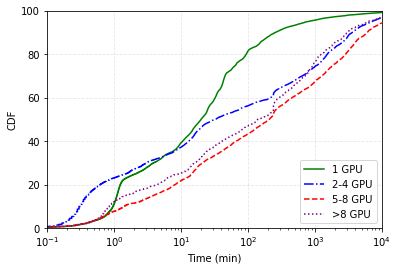

In [9]:
buckets = sorted([bucket for bucket in run_times])
for bucket in buckets:
    num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
    x, y = get_cdf(run_times[bucket])
    plt.plot(x, y, label='%s GPU' % (num_gpus), color=color, linestyle=linestyle)
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlim(10 ** -1, 10 ** 4)
plt.ylim(0, 100)
plt.xlabel('Time (min)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

# Queueing Delay (Figure 3)

In [10]:
queueing_delays = {}
for job in jobs:
    vc = job.vc
    if vc not in queueing_delays:
        queueing_delays[vc] = {}
    bucket = get_bucket_from_num_gpus(job.num_gpus)
    if bucket is None:
        continue
    if bucket not in queueing_delays[vc]:
        queueing_delays[vc][bucket] = []
    # NOTE: Each period between the job being placed on the queue
    # and being scheduled on a machine is recorded as an individual
    # queueing delay.
    queueing_delay = 0.0
    queue_time = job.submitted_time
    for attempt in job.attempts:
        start_time = attempt['start_time']
        if queue_time is not None and start_time is not None:
            queueing_delay = timedelta_to_minutes(start_time - queue_time)
            queue_time = attempt['end_time']
        queueing_delays[vc][bucket].append(queueing_delay)
for vc in queueing_delays:
    for bucket in queueing_delays[vc]:
        queueing_delays[vc][bucket] = filter(None, queueing_delays[vc][bucket])

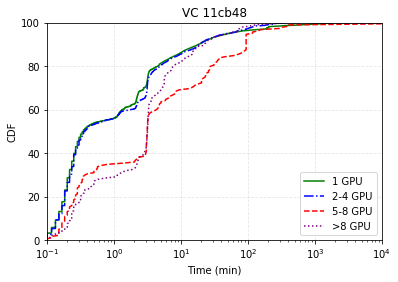

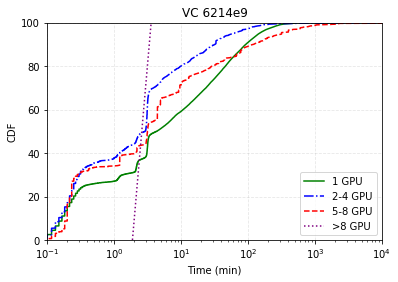

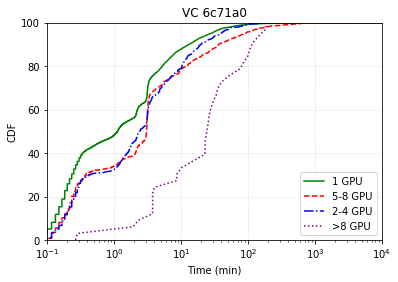

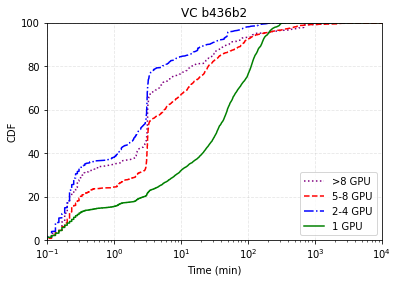

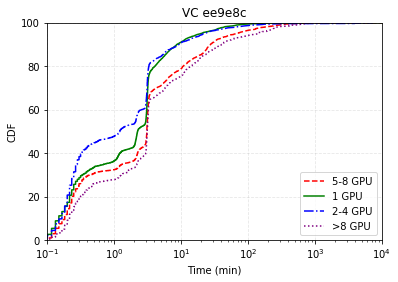

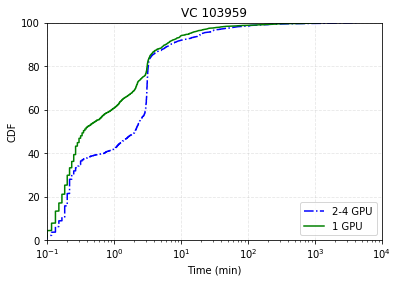

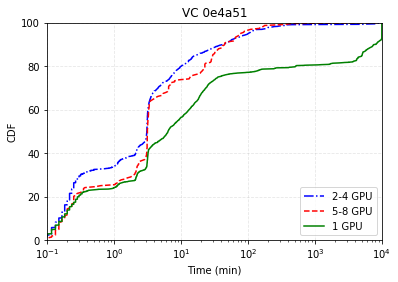

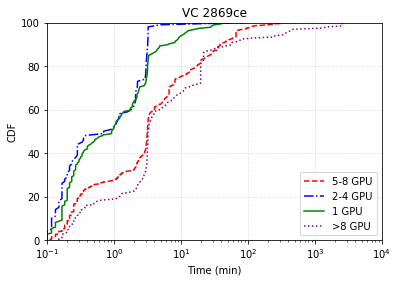

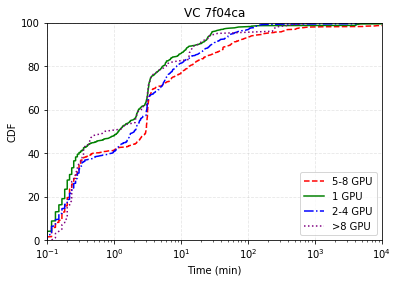

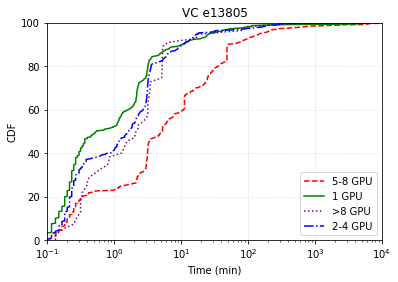

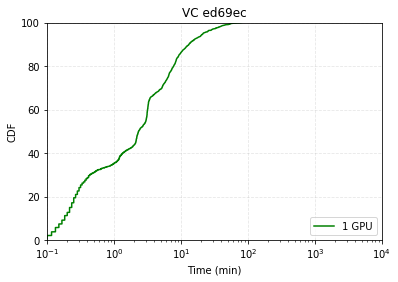

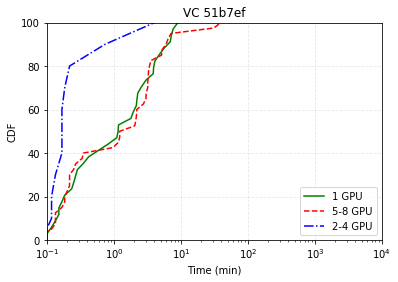

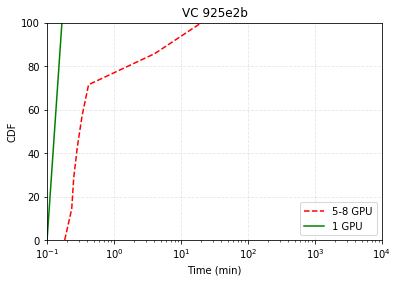

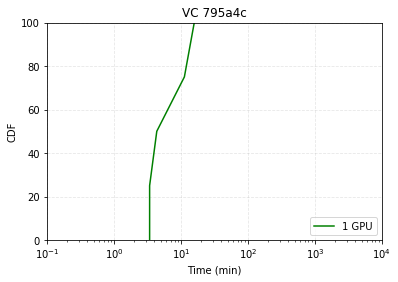

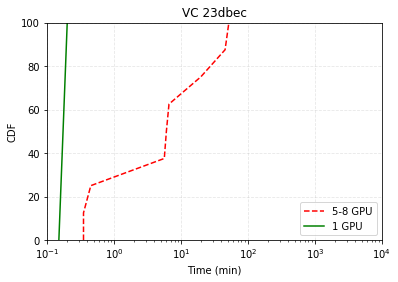

In [11]:
vcs = queueing_delays.keys()
for i, vc in enumerate(vcs):
    for bucket in queueing_delays[vc]:
        num_gpus, color, linestyle = get_plot_config_from_bucket(bucket)
        x, y = get_cdf(queueing_delays[vc][bucket])
        plt.plot(x, y, label='%s GPU' % (num_gpus), color=color, linestyle=linestyle)
    plt.title('VC %s' % (vc))
    plt.legend(loc='lower right')
    plt.xscale('log')
    plt.ylim(0, 100)
    plt.xlim(10 ** -1, 10 ** 4)
    plt.xlabel('Time (min)')
    plt.ylabel('CDF')
    plt.grid(alpha=.3, linestyle='--')
    if i < len(vcs) - 1:
        plt.figure()
plt.show()

# Locality Constraints (Figure 4)

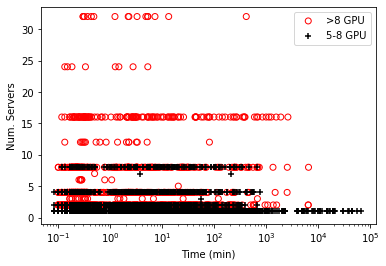

In [12]:
data = {}
for i, job in enumerate(jobs):
    if len(job.attempts) == 0:
        continue
    num_gpus = job.num_gpus
    if num_gpus < 5:
        continue
    bucket = get_bucket_from_num_gpus(num_gpus)
    if bucket not in data:
        data[bucket] = {
            'x': [],
            'y': []
        }
    queueing_delay = job.queueing_delay
    num_servers = len(job.attempts[0]['detail'])
    data[bucket]['x'].append(queueing_delay)
    data[bucket]['y'].append(num_servers)
for bucket in data:
    num_gpus, _, _ = get_plot_config_from_bucket(bucket)
    if bucket == 2:
        marker = '+'
        facecolors = 'black'
        edgecolors = 'none'
    else:
        marker = 'o'
        facecolors = 'none'
        edgecolors = 'red'
    plt.scatter(data[bucket]['x'], data[bucket]['y'], label='%s GPU' % (num_gpus),
                marker=marker, facecolors=facecolors, edgecolors=edgecolors)
    plt.legend()
plt.xscale('log')
plt.xlabel('Time (min)')
plt.ylabel('Num. Servers')
plt.show()

# GPU Utilization (Figures 5, 6)

In [13]:
gpu_util_path = os.path.join(LOGDIR, 'cluster_gpu_util')
gpu_util = {}
with open(gpu_util_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        time = row[0][:-4] # Remove the timezone
        machineId = row[1]
        if machineId not in gpu_util:
            gpu_util[machineId] = {}
        gpu_util[machineId][time] = row[2:-1] # Ignore extra empty string at the end

In [14]:
def get_utilization_data(jobs, only_large_jobs=False, only_dedicated_servers=False):
    """Aggregates GPU utilization data for a set of jobs.
    
       Args:
           jobs: A list of Jobs.
           only_large_jobs: If True, only considers jobs of size 8 or 16 GPUs.
                            Otherwise, considers jobs of size 1, 4, 8, or 16 GPUs.       
           only_dedicated_servers: If True, only considers jobs that use all GPUs
                                   available on a server(s).
       
       Returns:
           A dict indexed by 1) job completion status, 2) number of GPUs requested
           by the job, and 3) timestamp. The value of each nested dict is a list of
           percentages indicating the utilization of each individual GPU on the
           servers used by the job at the particular time requested.
    """
    data = {}
    for job in jobs:
        num_gpus = job.num_gpus
        if (len(job.attempts) == 0 or
            (num_gpus != 1 and num_gpus != 4 and num_gpus != 8 and num_gpus != 16)):
            continue
        if only_large_jobs and num_gpus < 8:
            continue
        status = job.status
        if status not in data:
            data[status] = {}
        if num_gpus not in data[status]:
            data[status][num_gpus] = []
        for attempt in job.attempts:
            if only_dedicated_servers and len(attempt['detail']) > (num_gpus / 8):
                continue
            current_time = attempt['start_time']
            if current_time is None or attempt['end_time'] is None:
                continue
            current_minute = round_to_nearest_minute(current_time)
            while current_minute < attempt['end_time']:
                current_minute_str = str(current_minute)
                for detail in attempt['detail']:
                    machineId = detail['ip']
                    if current_minute_str in gpu_util[machineId]:
                        for gpu_id in detail['gpus']:
                            gpu_num = int(gpu_id[3:]) # Remove the 'gpu' prefix
                            try:
                                u = gpu_util[machineId][current_minute_str][gpu_num]
                                if u != 'NA':
                                    data[status][num_gpus].append(float(u))
                            except Exception as e:
                                print(gpu_util[machineId][current_minute_str])
                                print(gpu_num)
                                raise ValueError(e)
                current_minute = add_minute(current_minute)
    return data

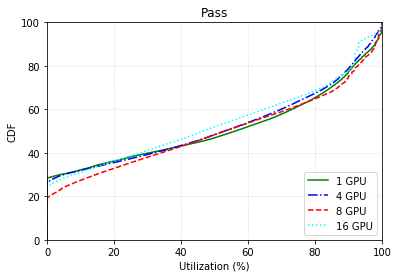

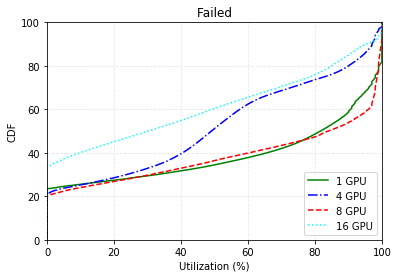

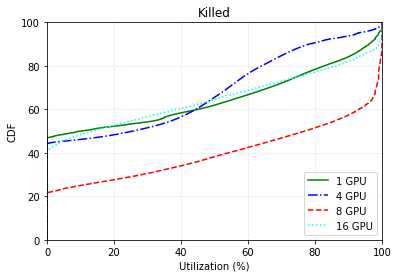

In [15]:
data = get_utilization_data(jobs)
statuses = data.keys()
for i, status in enumerate(statuses):
    all_num_gpus = sorted(data[status].keys())
    for num_gpus in all_num_gpus:
        if num_gpus == 1:
            color = 'green'
            linestyle = '-'
        elif num_gpus == 4:
            color = 'blue'
            linestyle = '-.'
        elif num_gpus == 8:
            color = 'red'
            linestyle = '--'
        elif num_gpus == 16:
            color = 'cyan'
            linestyle = ':'
        x, y = get_cdf(data[status][num_gpus])
        plt.plot(x, y, label='%s GPU' % (num_gpus), color=color, linestyle=linestyle)
    plt.title(status)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.legend(loc='lower right')
    plt.xlabel('Utilization (%)')
    plt.ylabel('CDF')
    plt.grid(alpha=.3, linestyle='--')
    if i < len(statuses) - 1:
        plt.figure()
plt.show()

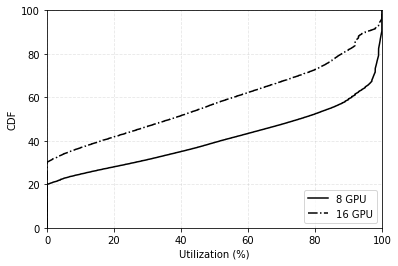

In [16]:
data = get_utilization_data(jobs, only_large_jobs=True, only_dedicated_servers=True)
aggregate_data = {}
for status in data:
    for num_gpus in data[status]:
        if num_gpus not in aggregate_data:
            aggregate_data[num_gpus] = []
        aggregate_data[num_gpus] += data[status][num_gpus]
all_num_gpus = sorted(aggregate_data.keys())
for num_gpus in all_num_gpus:
    if num_gpus == 8:
        linestyle = '-'
    elif num_gpus == 16:
        linestyle = '-.'
    x, y = get_cdf(aggregate_data[num_gpus])
    plt.plot(x, y, label='%s GPU' % (num_gpus), color='black', linestyle=linestyle)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(loc='lower right')
plt.xlabel('Utilization (%)')
plt.ylabel('CDF')
plt.grid(alpha=.3, linestyle='--')
plt.show()

# Host Resource Utilization (Figure 7)

In [17]:
mem_util_path = os.path.join(LOGDIR, 'cluster_mem_util')
mem_util = []
with open(mem_util_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        if row[2] == 'NA':
            continue
        mem_total = float(row[2])
        mem_free = float(row[3])
        if mem_total == 0:
            continue
        mem_util.append(100.0 * (mem_total - mem_free) / mem_total)

In [18]:
cpu_util_path = os.path.join(LOGDIR, 'cluster_cpu_util')
cpu_util = []
with open(cpu_util_path, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        if row[2] == 'NA':
            continue
        cpu_util.append(float(row[2]))

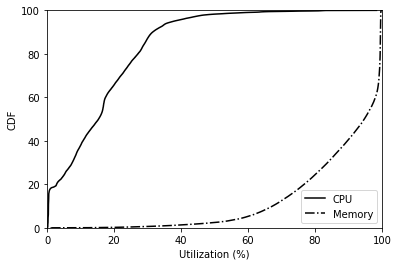

In [19]:
x, y = get_cdf(cpu_util)
plt.plot(x, y, label='CPU', color='black', linestyle='-')
x, y = get_cdf(mem_util)
plt.plot(x, y, label='Memory', color='black', linestyle='-.')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.legend(loc='lower right')
plt.xlabel('Utilization (%)')
plt.ylabel('CDF')
plt.show()